# Восстановление золота из руды

Подготовьте прототип модели машинного обучения. Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

### Технологический процесс

1. Флотация

    Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов. На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. Очистка

    Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Расчёт эффективности

Эффективность обогащения рассчитывается по формуле:

![title](./f.png)

где:

C — доля золота в концентрате после флотации/очистки; \
F — доля золота в сырье/концентрате до флотации/очистки; \
T — доля золота в отвальных хвостах после флотации/очистки.

# Описание данных

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate — ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи
Наименование признаков

Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]
Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.pipeline import  make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_train = pd.read_csv('./gold_recovery_train_new.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [3]:
data_test = pd.read_csv('./gold_recovery_test_new.csv')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [4]:
data_full = pd.read_csv('./gold_recovery_full_new.csv')
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Удалим пропуски в столбцах (rougher.output.concentrate_au, rougher.input.feed_au, rougher.output.tail_au, rougher.output.recovery), которые в дальнейшем потребуются для расчета эффективности обогащения:

In [5]:
data_train.dropna(subset=['rougher.output.concentrate_au', 'rougher.input.feed_au','rougher.output.tail_au',
                          'rougher.output.recovery'], inplace=True)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


### Рассчитаем эффективность обогащения

In [6]:
#рассчитаем эффективность обогащения
concentrate_au = data_train['rougher.output.concentrate_au']
feed_au = data_train['rougher.input.feed_au']
tail_au = data_train['rougher.output.tail_au']
recovery_reckoning = (concentrate_au * (feed_au - tail_au) / (feed_au * (concentrate_au - tail_au))) * 100
recovery_reckoning

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64

Найдем MAE:

In [7]:
recovery_data = data_train['rougher.output.recovery']
print('Абсолютная средняя ошибка = {:.15f}'. format(mean_absolute_error(recovery_data, recovery_reckoning)))

Абсолютная средняя ошибка = 0.000000000000010


Отклонение очень маленькое. Значит, посчитанные данные совпадают с rougher.output.recovery.

### Проанализируем признаки, недоступные в тестовой выборке

Если посмотреть на таблицы data_train и data_test, то их количество столбцов расходится: data_train (87 столбцов),  data_test (53 столбца). 

In [8]:
data_train.shape

(14149, 87)

In [9]:
data_test.shape

(5290, 53)

In [10]:
print('Количество параметров, отсутствующих в тестовой выборке:' , len(set(data_train) - set(data_test)))
set(data_train.columns) - set(data_test.columns)

Количество параметров, отсутствующих в тестовой выборке: 34


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Возможно некоторые данные недоступны в связи с тем, что данные измеряются или рассчитываются значительно позже, поэтому 34 параметра отсутствуют в тестовой выборке.

### Проведем предобработку данных.

In [11]:
#посмотрим пропуски
data_train.isnull().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [12]:
#удалим пропуски
data_train = data_train.dropna()

In [13]:
#дубликатов нет
data_train.duplicated().sum()

0

In [14]:
#посмотрим пропуски
data_test.isnull().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [15]:
#удалим пропуски
data_test = data_test.dropna()

In [16]:
#дубликатов нет
data_test.duplicated().sum()

0

In [17]:
#посмотрим пропуски
data_full.isnull().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [18]:
#удалим пропуски
data_full = data_full.dropna()

In [19]:
#дубликатов нет
data_full.duplicated().sum()

0

Вывод:

- вручную посчитали эффективность обогащения, сравнили с rougher.output.recovery, отклонение очень маленькое (MAE=0.000000000000009)
- количество параметров, отсутствующих в тестовой выборке: 34. Возможно эти данные недоступны в связи с тем, что измеряются или рассчитываются значительно позже.
- удалили пропуски, дубликатов нет

## Анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb)

#### Изменение концентрации золота

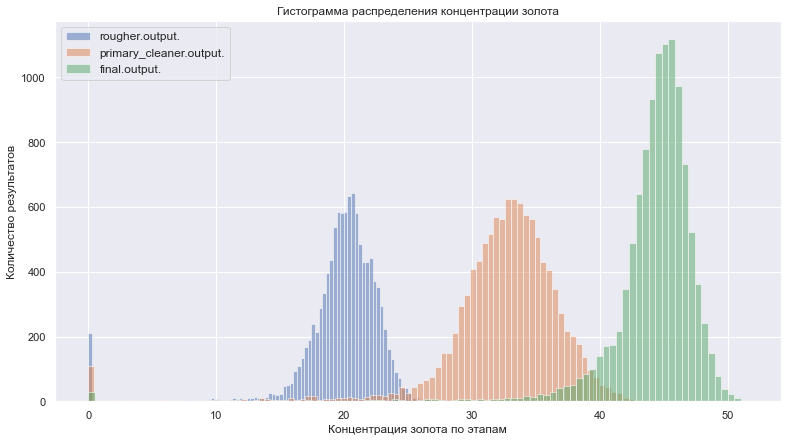

In [20]:
plt.figure(figsize=[13,7])

sns.set(style="darkgrid")
plt.hist(data_train['rougher.output.concentrate_au'], bins=100, label='rougher.output.', alpha=0.5)
plt.hist(data_train['primary_cleaner.output.concentrate_au'], bins=100, label='primary_cleaner.output.', alpha=0.5)
plt.hist(data_train['final.output.concentrate_au'], bins=100, label='final.output.', alpha=0.5)


plt.xlabel('Концентрация золота по этапам')
plt.ylabel('Количество результатов')

plt.legend(loc='upper left', fontsize='medium')

plt.title('Гистограмма распределения концентрации золота')
plt.show()

На графике видно, что концентрация золота с каждым этапом увеличивается, что и требовалось после флотации и очистки. Есть аномальные значения в 0 и выбросы в rougher от 0 до 15, в cleaner от 0 до 25 и в final от 0 до 35. Избавимся от них, так как аномальные значения находятся далеко от нашего распределения и выбросы, чтобы распределение было более точным.

In [21]:
#удалили аномальные значения и избавимся от выбросов
data_train = data_train.drop(data_train[data_train['rougher.output.concentrate_au'] < 15].index)
data_train = data_train.drop(data_train[data_train['primary_cleaner.output.concentrate_au'] < 25].index)
data_train = data_train.drop(data_train[data_train['final.output.concentrate_au'] < 35].index)

#### Изменение концентрации серебра

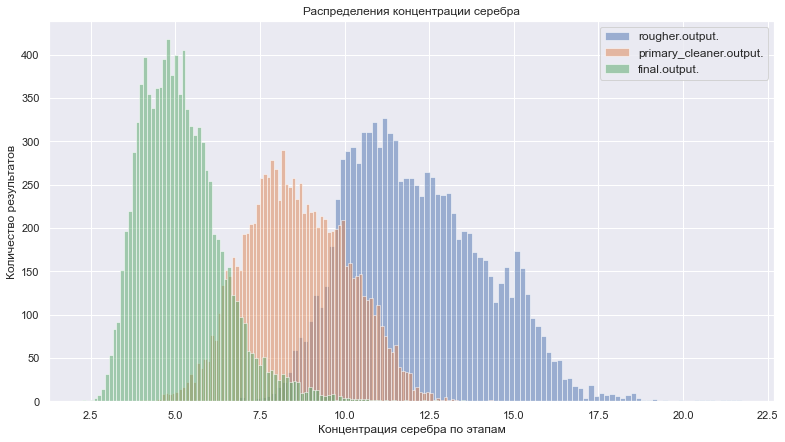

In [22]:
plt.figure(figsize=[13,7])

plt.hist(data_train['rougher.output.concentrate_ag'], bins=100, label='rougher.output.', alpha=0.5)
plt.hist(data_train['primary_cleaner.output.concentrate_ag'], bins=100, label='primary_cleaner.output.', alpha=0.5)
plt.hist(data_train['final.output.concentrate_ag'], bins=100, label='final.output.', alpha=0.5)


plt.xlabel('Концентрация серебра по этапам')
plt.ylabel('Количество результатов')

plt.legend(loc='upper right', fontsize='medium')

plt.title('Распределения концентрации серебра')
plt.show()

Концентрация серебра уменьшается с каждым шагом очистки, так как основным металлом является золото.

#### Изменение концентрации свинца.

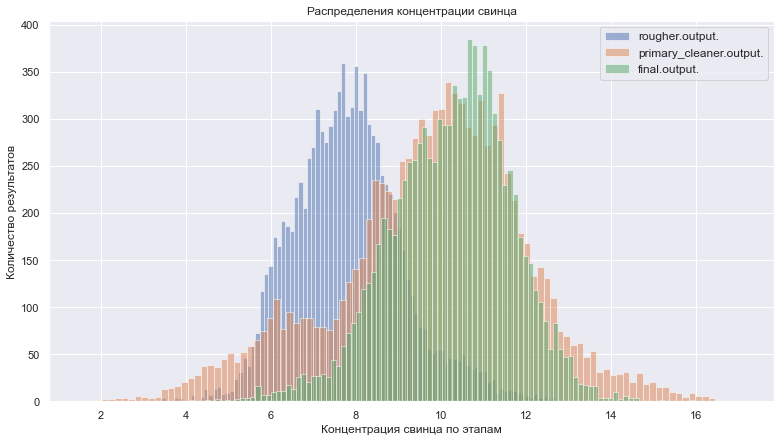

In [23]:
plt.figure(figsize=[13,7])

sns.set(style="darkgrid")
plt.hist(data_train['rougher.output.concentrate_pb'], bins=100, label='rougher.output.', alpha=0.5)
plt.hist(data_train['primary_cleaner.output.concentrate_pb'], bins=100, label='primary_cleaner.output.', alpha=0.5)
plt.hist(data_train['final.output.concentrate_pb'], bins=100, label='final.output.', alpha=0.5)


plt.xlabel('Концентрация свинца по этапам')
plt.ylabel('Количество результатов')

plt.legend(loc='upper right', fontsize='medium')

plt.title('Распределения концентрации свинца')
plt.show()

Концентрация свинца увеличивается с флотации до очистки и пытается сравняться с финальными характеристиками. Это связано с химическими процессами очищения золота.

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

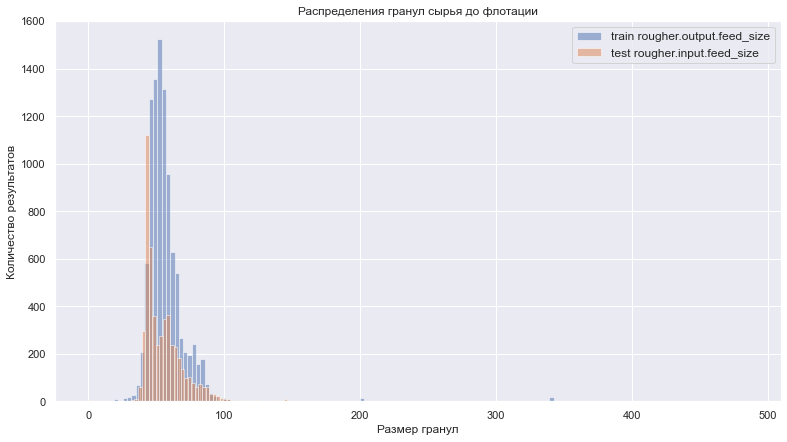

In [24]:
plt.figure(figsize=[13,7])

plt.hist(data_train['rougher.input.feed_size'], bins=150, label='train rougher.output.feed_size', alpha=0.5)
plt.hist(data_test['rougher.input.feed_size'], bins=150, label='test rougher.input.feed_size', alpha=0.5)


plt.xlabel('Размер гранул')
plt.ylabel('Количество результатов')

plt.legend(loc='upper right', fontsize='medium')

plt.title('Распределения гранул сырья до флотации')
plt.show()

Распределения гранул сырья между обучающей и тестовой выборках похожее, оба смещаются влево.

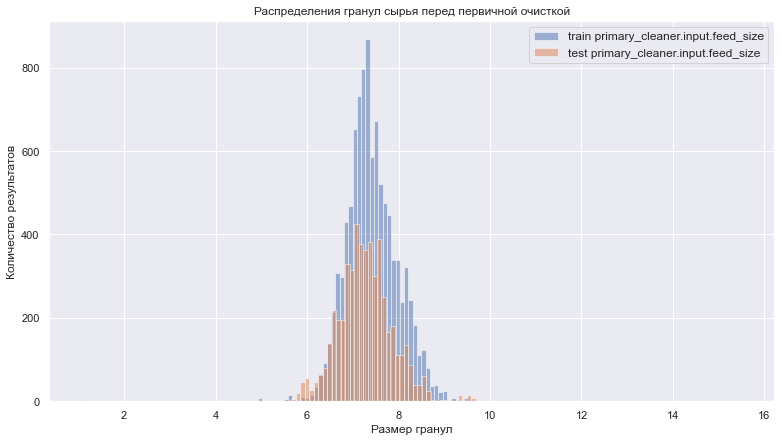

In [25]:
plt.figure(figsize=[13,7])

plt.hist(data_train['primary_cleaner.input.feed_size'], bins=100, label='train primary_cleaner.input.feed_size', 
         alpha=0.5)
plt.hist(data_test['primary_cleaner.input.feed_size'], bins=100, label='test primary_cleaner.input.feed_size', 
         alpha=0.5)


plt.xlabel('Размер гранул')
plt.ylabel('Количество результатов')

plt.legend(loc='upper right', fontsize='medium')

plt.title('Распределения гранул сырья перед первичной очисткой')
plt.show()

Распределение гранул сырья одинаковое (Нормальное распределение).

### Исследуем суммарную концентрацию всех веществ на разных стадиях.

Суммируем концентрацию всех веществ:

In [26]:
sum_rougher_output_concentrate_train = (data_train['rougher.output.concentrate_ag'] + 
                                    data_train['rougher.output.concentrate_pb'] + 
                                    data_train['rougher.output.concentrate_sol'] + 
                                    data_train['rougher.output.concentrate_au'])

sum_primary_cleaner_output_concentrate_train = (data_train['primary_cleaner.output.concentrate_ag'] + 
                                            data_train['primary_cleaner.output.concentrate_pb'] + 
                                            data_train['primary_cleaner.output.concentrate_sol'] + 
                                            data_train['primary_cleaner.output.concentrate_au'])

sum_final_output_concentrate_train = (data_train['final.output.concentrate_ag'] + 
                                  data_train['final.output.concentrate_pb'] + 
                                  data_train['final.output.concentrate_sol'] + 
                                  data_train['final.output.concentrate_au'])

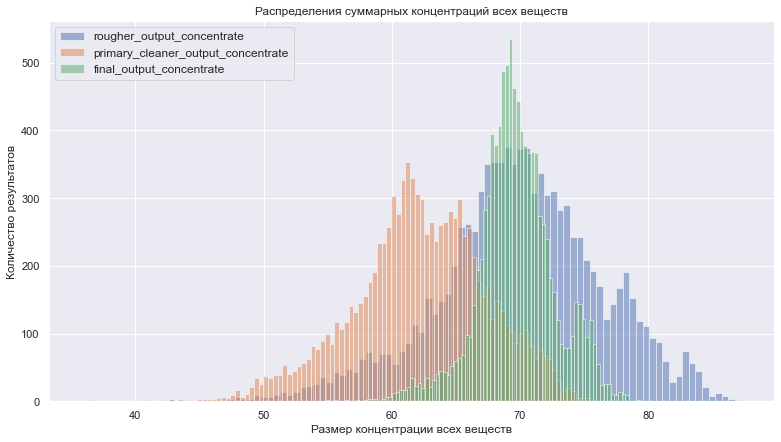

In [27]:
plt.figure(figsize=[13,7])

plt.hist(sum_rougher_output_concentrate_train, bins=100, label='rougher_output_concentrate', 
         alpha=0.5)
plt.hist(sum_primary_cleaner_output_concentrate_train, bins=100, label='primary_cleaner_output_concentrate', 
         alpha=0.5)
plt.hist(sum_final_output_concentrate_train, bins=100, label='final_output_concentrate', 
         alpha=0.5)


plt.xlabel('Размер концентрации всех веществ')
plt.ylabel('Количество результатов')

plt.legend(loc='upper left', fontsize='medium')

plt.title('Распределения суммарных концентраций всех веществ')
plt.show()

Аномальных значений нет, так как мы избавились от них выше.

Вывод:

    - проанализировали, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки;
    - нашли аномалии в 0 и выбросы, удалили их;
    - сравнили распределения размеров гранул сырья на обучающей и тестовой выборках (распределения похожие);
    - исследовали суммарную концентрацию всех веществ (аномалий больше не нашли).

## Модель

In [28]:
#удалим столбец дата, так как он не содержит важных данных
data_test_no = data_test.drop('date',axis = 1)
data_train_no = data_train.drop('date',axis = 1)

In [29]:
#выберем признаки
train_features_data_rougher = data_train_no.loc[:,data_test_no.columns]
train_target_data_rougher = data_train_no['rougher.output.recovery']
train_features_data_final = train_features_data_rougher 
train_target_data_final = data_train_no['final.output.recovery']

### Функция для вычисления итоговой sMAPE

![title](./model.png)

In [30]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    total = 0
    for i in range(len(y_true)):
        total += abs(y_true[i] - y_pred[i]) / ( (abs(y_true[i]) + abs(y_pred[i]) )/2)
        smape = abs(total*100 / len(y_true))
    return abs(smape)

In [31]:
def final_sMAPE(smape_rougher,smape_final):
    return (0.25*smape_rougher + 0.75*smape_final)

In [32]:
custom_score = make_scorer(smape,greater_is_better=False)

### Обучим разные модели и оценим их качество

Подготовим pipeline

In [33]:
model_1 = make_pipeline(StandardScaler(),RandomForestRegressor())
model_2 = make_pipeline(StandardScaler(),DecisionTreeRegressor())

In [34]:
#параметров для GridSearchCV
params_RF = {"randomforestregressor__n_estimators":[5,100],
             "randomforestregressor__max_depth":[1,10]}
params_DT= {"decisiontreeregressor__max_depth":[1,10]}

In [35]:
grid_rougher = GridSearchCV(model_1,param_grid = params_RF,scoring=custom_score)
grid_final = GridSearchCV(model_1,param_grid = params_RF,scoring=custom_score)
grid_rougher_DT = GridSearchCV(model_2,param_grid = params_DT,scoring=custom_score)
grid_final_DT = GridSearchCV(model_2,param_grid = params_DT,scoring=custom_score)

Обучение:

In [36]:
grid_rougher.fit(train_features_data_rougher, train_target_data_rougher)
grid_final.fit(train_features_data_final, train_target_data_final)
grid_rougher_DT.fit(train_features_data_rougher, train_target_data_rougher)
grid_final_DT.fit(train_features_data_final, train_target_data_final)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__max_depth': [1, 10]},
             scoring=make_scorer(smape, greater_is_better=False))

In [37]:
print("Лучшие модели")
print(grid_rougher.best_estimator_)
print(grid_final.best_estimator_)
print(grid_rougher_DT.best_estimator_)
print(grid_final_DT.best_estimator_)

Лучшие модели
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_estimators=5))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor(max_depth=1))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=1))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=1))])


In [38]:
best_score_rougher = grid_rougher.best_score_
best_score_final = grid_final.best_score_
best_score_rougher_DT = grid_rougher_DT.best_score_
best_score_final_DT = grid_final_DT.best_score_

Определим лучшую модель для каждого целевого признака

In [39]:
print("rougher")
print("RandomForest",best_score_rougher,"DecisionTree",best_score_rougher_DT)
print("final")
print("RandomForest",best_score_final,"DecisionTree",best_score_final_DT)

rougher
RandomForest -6.140302670639414 DecisionTree -6.939490944679487
final
RandomForest -7.903555045124328 DecisionTree -7.952142401430857


Видно, что лучше всего подходит модель RandomForest

### Лучшие результаты на тренировочной выборке


In [40]:
print('Финальный sMAPE рандомного леса: {:.2f}'. format(final_sMAPE(best_score_rougher,best_score_final)))
print('Финальный sMAPE решающего дерева: {:.2f}'. format(final_sMAPE(best_score_rougher_DT,best_score_final_DT)))

Финальный sMAPE рандомного леса: -7.46
Финальный sMAPE решающего дерева: -7.70


Наименьшую ошибку мы получили при использовании рандомного леса

In [41]:
#предсказания на тестовой выборке
rogher_test = grid_rougher.predict(data_test_no)
final_test = grid_final.predict(data_test_no)

In [42]:
test_frame_for_target = data_test.merge(data_full.loc[:,['date',"rougher.output.recovery","final.output.recovery"]],
                                        on = 'date')
target_test_rougher = test_frame_for_target["rougher.output.recovery"]
target_test_final = test_frame_for_target["final.output.recovery"]

In [43]:
print('Финальная ошибка на тестовой выборке: {:.2f}'. format(final_sMAPE(smape(target_test_rougher,rogher_test),
                                                          smape(target_test_final,final_test))))

Финальная ошибка на тестовой выборке: 8.75


### Подготовим и обучим константную модель

In [44]:
base = DummyRegressor(strategy="median")
base_final = DummyRegressor(strategy="median")

In [45]:
base.fit(train_features_data_rougher,train_target_data_rougher)
base_final.fit(train_features_data_final,train_target_data_final)

DummyRegressor(strategy='median')

Предскажем метки

In [46]:
base_rougher = base.predict(data_test_no)
base_final_pred = base_final.predict(data_test_no)

In [47]:
final_sMAPE(smape(target_test_rougher,base_rougher),smape(target_test_final,base_final_pred))

8.55653196849559

Вывод:

    Была написана функция для вычисления sMAPE. 
    Самая лучшая модель - RandomForest. Ее значение sMAPE самое низкое.

## Вывод:

В ходе работы было выполнено:
    
* подготовлены данные;
* проведен исследовательский анализ данных;
* построена и обучена модель.

Самая лучшая модель - RandomForest с параметрами max_depth=10, n_estimators=100. Ее значение sMAPE самое низкое 8.85. Если сравнивать с константной моделью, значение проигрывает на 0.3 
       